In [1]:
import copy
import numpy as np
import os

In [2]:
import analysis_config

In [3]:
import verdict
import galaxy_dive.analyze_data.particle_data as particle_data
import galaxy_dive.read_data.metafile as read_metafile
import galaxy_dive.utils.executable_helpers as exec_helpers
import galaxy_dive.plot_data.plotting as generic_plotting
import galaxy_dive.trends.galaxy as galaxy_trends

/home1/03057/zhafen/.local/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
import linefinder.config as linefinder_config
import linefinder.utils.file_management as file_management

In [5]:
import colossus.cosmology.cosmology as co_cosmology

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.patheffects as path_effects
import matplotlib.transforms as transforms

# Load Data

In [7]:
do_calculation = False

In [8]:
snum, galdef_name = exec_helpers.choose_config_or_commandline(
    [ analysis_config.SNUM, analysis_config.GALDEF ]
)
print( 'Using snum {}, galdef {}'.format( snum, galdef_name ) )

Using snum 600, galdef _galdefv3


In [9]:
galdef = linefinder_config.GALAXY_DEFINITIONS[galdef_name]

In [10]:
file_manager = file_management.FileManager( project='CGM_origin' )

In [11]:
cp_file_manager = file_management.FileManager( project='code_paper' )

In [12]:
sim_names = analysis_config.SIM_NAMES

In [13]:
all_results = verdict.Dict( {
    'M' : {
        'gas' : {},
        'stars' : {},
        'total' : {},
    },
    'enriched_metal_mass' : {
        'gas' : {},
        'stars' : {},
        'total' : {},
    },
    'R' : {},
} )

In [14]:
if do_calculation:
    for sim_name in sim_names:

        print( 'Getting data for {}'.format( sim_name ) )

        g_data = particle_data.ParticleData(
            sdir = file_manager.get_sim_dir( sim_name ),
            halo_data_dir = file_manager.get_halo_dir( sim_name ),
            snum = snum,
            ptype = 0,
            main_halo_id = linefinder_config.MAIN_MT_HALO_ID[sim_name],
        )

        s_data = particle_data.ParticleData(
            sdir = file_manager.get_sim_dir( sim_name ),
            halo_data_dir = file_manager.get_halo_dir( sim_name ),
            snum = snum,
            ptype = 4,
            main_halo_id = linefinder_config.MAIN_MT_HALO_ID[sim_name],
        )

        # For more convenient access
        datas = verdict.Dict( {
            'gas' : g_data,
            'stars' : s_data,
        })

        metafile_reader = read_metafile.MetafileReader(
            file_manager.get_metafile_dir( sim_name )
        )

        def store_or_create( results_dict, value, name ):
            try:
                results_dict[name][sim_name] = value
            except KeyError:
                results_dict[name] = verdict.Dict( {} )
                results_dict[name][sim_name] = value

        def store_results( results, data_to_store, name ):

            total = 0.
            for key, item in data_to_store.items():
                store_or_create( results[key], item, name)
                total += item

            store_or_create( results['total'], total, name )

        # Mask Data

        datas.data_masker.clear_masks( True )

        # Mask all data outside the halo
        datas.data_masker.mask_data(
            'R',
            -np.inf,
            g_data.r_vir,
            optional_mask = True,
            mask_name = 'is_in_halo',
        )

        length_scale = g_data.halo_data.get_mt_data(
            galdef['mt_length_scale'], 
            mt_halo_id = linefinder_config.MAIN_MT_HALO_ID[sim_name], 
            snums = [ snum ],
            a_power = 1.,
        )[0] / g_data.data_attrs['hubble']

        r_gal = length_scale * galdef['galaxy_cut']

        # Mask all data outside the galaxy
        datas.data_masker.mask_data(
            'R',
            -np.inf,
            r_gal,
            optional_mask = True,
            mask_name = 'is_in_gal_radius',
        )

        # Different masks for multiples of the length scale
        for cut in np.arange( 1., 7., 1.):
            datas.data_masker.mask_data(
                'R',
                -np.inf,
                length_scale * cut,
                optional_mask = True,
                mask_name = cut,
            )

        # Mask all data outside the galaxy density cut
        g_data.data_masker.mask_data(
            'NumDen',
            0.1,
            np.inf,
            optional_mask = True,
            mask_name = 'is_in_gal_density',
        )

        r_inner_cgm_rgal = r_gal * ( 1. + linefinder_config.F_GAP )

        # Mask all data outside the CGM (outside galaxy scale)
        datas.data_masker.mask_data(
            'R',
            r_inner_cgm_rgal,
            linefinder_config.OUTER_CGM_BOUNDARY * g_data.r_vir,
            optional_mask = True,
            mask_name = 'is_in_CGM_outside_gal',
        )

        # Mask all data outside the CGM (Rvir scale)
        datas.data_masker.mask_data(
            'R',
            linefinder_config.INNER_CGM_BOUNDARY * g_data.r_vir,
            linefinder_config.OUTER_CGM_BOUNDARY * g_data.r_vir,
            optional_mask = True,
            mask_name = 'is_in_CGM_virial_scale',
        )
        
        # Select outer CGM data
        datas.data_masker.mask_data(
            'R',
            0.5 * g_data.r_vir,
            linefinder_config.OUTER_CGM_BOUNDARY * g_data.r_vir,
            optional_mask = True,
            mask_name = 'is_in_outer_CGM',
        )

        # Select for data that's not in either the galaxy or the CGM

        is_not_in_gals = verdict.Dict( {} )
        is_not_in_gals['gas'] = np.ma.mask_or(
            datas['gas'].data_masker.optional_masks['is_in_gal_radius']['mask'],
            datas['gas'].data_masker.optional_masks['is_in_gal_density']['mask'],
        )
        is_not_in_gals['stars'] = datas['stars'].data_masker.optional_masks['is_in_gal_radius']['mask']

        is_not_in_CGMs = verdict.Dict( {} )
        for key, data in datas.items():
            is_not_in_CGMs[key] = np.ma.mask_or(
                data.data_masker.optional_masks['is_in_CGM_outside_gal']['mask'],
                data.data_masker.optional_masks['is_in_CGM_virial_scale']['mask'],
            )

        # Choose different temperature cuts
        g_data.data_masker.mask_data(
            'T',
            -np.inf,
            1e4,
            optional_mask = True,
            mask_name = 'cold',
        )
        g_data.data_masker.mask_data(
            'T',
            1e4,
            10.**4.7,
            optional_mask = True,
            mask_name = 'cool',
        )
        g_data.data_masker.mask_data(
            'T',
            10.**4.7,
            10.**5.3,
            optional_mask = True,
            mask_name = 'warm',
        )
        g_data.data_masker.mask_data(
            'T',
            10.**5.3,
            np.inf,
            optional_mask = True,
            mask_name = 'hot',
        )

        for key, data in datas.items():

            is_not_in_gal_or_in_CGM = is_not_in_gals[key] & is_not_in_CGMs[key]

            data.data_masker.mask_data(
                'is_not_in_gal_or_in_CGM',
                custom_mask = np.invert( is_not_in_gal_or_in_CGM ),
                optional_mask = True,
            )

        ## Get the total baryonic halo mass

        for mass_type in [ 'M', 'enriched_metal_mass' ]:

            results = all_results[mass_type]

            m_halos = datas.get_selected_data( 
                mass_type, 
                optional_masks=[ 'is_in_halo' ],
            ).sum() * 1e10

            store_results( results, m_halos, 'm_halo' )

            ### Get the mass in the galaxy

            # Get the total baryonic mass in the halo
            m_gas_gal = g_data.get_selected_data( 
                mass_type, 
                optional_masks=[ 'is_in_gal_radius', 'is_in_gal_density' ] 
            ).sum() * 1e10 # To convert to the right units
            m_star_gal = s_data.get_selected_data( 
                mass_type, 
                optional_masks=[ 'is_in_gal_radius', ]
            ).sum() * 1e10 # To convert to the right units 

            m_gals = {
                'gas' : m_gas_gal,
                'stars' : m_star_gal,
            }

            store_results( results, m_gals, 'm_gal' )

            ### Get mass in the CGM

            m_cgms = datas.get_selected_data( 
                mass_type, 
                optional_masks=[ 'is_in_CGM_virial_scale', 'is_in_CGM_outside_gal' ]
            ).sum() * 1e10

            store_results( results, m_cgms, 'm_cgm' )
            
            ### Get mass in the outer CGM

            m_cgms = datas.get_selected_data( 
                mass_type, 
                optional_masks=[ 'is_in_outer_CGM', ]
            ).sum() * 1e10

            store_results( results, m_cgms, 'm_cgm_outer' )

            ### Find material that's in the halo, but is not part of any other category

            m_interface = datas.get_selected_data( 
                mass_type, 
                optional_masks=[ 'is_not_in_gal_or_in_CGM', 'is_in_halo' ],
            ).sum() * 1e10

            store_results( results, m_interface, 'm_interface' )

            ### Find the  mass of dense gas that's interfaceegorized (i.e. dense gas from R_gal to R_CGM )

            m_dense_interface = g_data.get_selected_data(
                mass_type, 
                optional_masks=[ 'is_not_in_gal_or_in_CGM', 'is_in_halo', 'is_in_gal_density' ],
            ).sum() * 1e10

            store_or_create( results['gas'], m_dense_interface, 'm_dense_interface' )

            ### Get total mass in the simulation

            m_box = datas.get_selected_data( 
                mass_type, 
            ).sum() * 1e10

            store_results( results, m_box, 'm_box' )

            ### Get mass in different cuts
            for cut in np.arange( 1., 7., 1. ):
                m_cut = datas.get_selected_data( 
                    mass_type, 
                    optional_masks=[ cut ],
                ).sum() * 1e10

                store_results( results, m_cut, cut )
                
                m_cut = g_data.get_selected_data(
                    mass_type,
                    optional_masks=[ cut, 'is_in_gal_density' ],
                ).sum() * 1e10

                store_or_create( results['gas'], m_cut, 'dense_{}'.format( cut ) )

            ### Get mass in different temperature regimes
            for phase in [ 'cold', 'cool', 'warm', 'hot' ]:
                m_phase = g_data.get_selected_data( 
                    mass_type, 
                    optional_masks=[ phase, 'is_in_CGM_virial_scale', 'is_in_CGM_outside_gal' ],
                ).sum() * 1e10

                store_or_create( results['gas'], m_phase, 'm_{}'.format( phase ) )

            ### Calculate the amount of dense CGM gas
            m_dense_cgm = g_data.get_selected_data(
                mass_type, 
                optional_masks=[ 'is_in_gal_density', 'is_in_CGM_virial_scale', 'is_in_CGM_outside_gal' ],
            ).sum() * 1e10

            store_or_create( results['gas'], m_dense_cgm, 'm_dense_cgm' )

        ### Get the baryonic halo budget

        metafile_reader.get_used_parameters()

        # Setup the cosmology used by the simulations                                   
        sim_cosmo = {                                                                   
            'flat': True,                                                                 
            'H0' : float( metafile_reader.used_parameters['HubbleParam'] )*100.,          
            'Om0' : float( metafile_reader.used_parameters['Omega0'] ),                   
            'Ob0' : float( metafile_reader.used_parameters['OmegaBaryon'] ),              
            'sigma8' : co_cosmology.cosmologies['WMAP9']['sigma8'], # Use WMAP9 for values we don't store in our simulations explicitly.
            'ns' : co_cosmology.cosmologies['WMAP9']['ns'], # Use WMAP9 for values we don't store in our simulations explicitly.
        }                                                                               
        cosmo = co_cosmology.setCosmology( 'sim_cosmo', sim_cosmo ) 

        omega_baryon = cosmo.Ob( g_data.redshift )

        omega_matter = cosmo.Om( g_data.redshift )

        store_or_create( all_results['M']['total'], g_data.m_vir * omega_baryon / omega_matter, 'm_budget_halo' )

        # Get metal budget
        m_floor = all_results['M']['total']['m_halo'][sim_name] * g_data.get_data( 'Z' ).min()   
        store_or_create( all_results['enriched_metal_mass']['total'], m_floor, 'm_floor' )

        m_floor_box = all_results['M']['total']['m_box'][sim_name] * g_data.get_data( 'Z' ).min()

        metals_produced = all_results['enriched_metal_mass']['total']['m_box'][sim_name]

        box_yield = metals_produced / all_results['M']['stars']['m_box'][sim_name]

        store_or_create( 
            all_results['enriched_metal_mass']['total'], 
            all_results['M']['stars']['m_gal'][sim_name] * box_yield, 
            'm_budget_halo',
        )
        store_or_create( 
            all_results['enriched_metal_mass']['total'], 
            all_results['M']['stars']['m_halo'][sim_name] * box_yield, 
            'm_budget_halo_all',
        )
        
#         # Get the metallicity
#         Z = g_data.get_data(
#             'Z',
#             optional_masks=[ 'is_in_CGM_virial_scale', 'is_in_CGM_outside_gal' ]
#         )
#         M = g_data.get_data(
#             'M',
#             optional_masks=[ 'is_in_CGM_virial_scale', 'is_in_CGM_outside_gal' ]
#         )
#         mean_metallicity = ( Z*M ).sum() / M.sum()
#         store_or_create(
#             all_results['enriched_metal_mass']['total']
#         )
        
        # Store virial mass
        store_or_create( all_results['M']['total'], g_data.m_vir,  'm_vir' )

        # Store radii
        store_or_create( all_results['R'], g_data.r_vir, 'r_vir' )
        store_or_create( all_results['R'], r_gal, 'r_gal' )
        
        #  Get the number of particles (and non-split particles) in the CGM
        cgm_ids = datas.get_selected_data( 
            'ID', 
            optional_masks=[ 'is_in_CGM_virial_scale', 'is_in_CGM_outside_gal' ]
        )
        n_particles_cgm = cgm_ids.size 
        n_unique_particles_cgm = cgm_ids.apply( np.unique ).size
        store_results( all_results['M'], n_particles_cgm, 'n_particles_cgm' )
        store_results( all_results['M'], n_unique_particles_cgm, 'n_unique_particles_cgm' )

        #  Get the number of particles (and non-split particles) in the galaxy
        gal_ids = verdict.Dict( { 
            'gas' : g_data.get_selected_data( 
                'ID', 
                optional_masks=[ 'is_in_gal_density', 'is_in_gal_radius' ]
            ),
            'stars' : s_data.get_selected_data( 
                'ID', 
                optional_masks=[ 'is_in_gal_radius' ]
            ),
        } )
        n_particles_gal = gal_ids.size 
        n_unique_particles_gal = gal_ids.apply( np.unique ).size
        store_results( all_results['M'], n_particles_gal, 'n_particles_gal' )
        store_results( all_results['M'], n_unique_particles_gal, 'n_unique_particles_gal' )

In [15]:
print 'Done!'

Done!


## Store and Load Data

In [16]:
savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'halo_mass_content_FIRE2_snum{}.hdf5'.format( snum ),
)

In [17]:
if do_calculation:
    all_results.to_hdf5(
        savefile, 
        condensed = True, 
        attributes = { 'redshift': g_data.redshift },
    )
    
    redshift = g_data.redshift

In [18]:
if not do_calculation:
    all_results, attributes = verdict.Dict.from_hdf5( savefile, unpack=True )
    
    redshift = attributes['redshift']

# Plots!

In [19]:
import palettable
import galaxy_dive.plot_data.qual_colormaps as qual_colormaps

In [20]:
colormap = palettable.cartocolors.qualitative.Vivid_3.mpl_colors

In [21]:
markers = {
    'm_halo' : 's',
    'm_cgm' : 'o',
    'm_interface' : 'p',
    'm_gal' : 'D',
}
colors = {
    'm_halo' : 'k',
    'm_cgm' : colormap[0],
    'm_interface' : colormap[2],
    'm_gal' : colormap[1],
}
labels = {
    'm_halo' : 'total',
    'm_cgm' : 'CGM',
    'm_interface' : 'galaxy-halo interface',
    'm_gal' : 'galaxy',
}
x_adjustment = {
    'm_halo' : 1.,
    'm_cgm' : 1.,
    'm_interface' : 1.025,
    'm_gal' : 0.95,
}
linewidths = {
    'm_halo' : 6,
    'm_cgm' : 5.,
    'm_interface' : 3.,
    'm_gal' : 4., 
}
category_ptypes = {
    'm_halo' : 'total',
    'm_cgm' : 'gas',
    'm_gal' : 'total',
    'm_interface' : 'gas',
}
met_budget_stellar_mass_keys = {
    'm_halo' : 'm_budget_halo_all',
    'm_cgm' : 'm_budget_halo_all',
    'm_gal' : 'm_budget_halo',
    'm_interface' : 'm_budget_halo',
}

In [22]:
def mass_budget_plot(
    x_data_type = 'm_vir',
    y_data_type = 'mass',
    fig_and_ax = None,
    enforce_lower_limit = False,
    lower_limit = 0.01,
    log_y = True,
    include_legend = False,
    categories = [ 'm_halo', 'm_cgm', 'm_gal', 'm_interface', ],
    md_split_categories = [],
    hline = None,
    x_label = ( snum == 172),
    y_range = [ 3e-2, 1 ],
    redshift_coords = ( 0.5, 0.1 ),
    redshift_ha = 'center',
    redshift_va = 'top',
    box_plot = True,
    plot_box_lines_only = False,
    save_plot = True,
    point_alpha = None,
    halo_point_size = 150,
    custom_legend_kwargs = None,
    overriding_label = None,
    use_minor_tick_formatter = False,
    save_file_tag = '',
    save_in_figure_dir = False,
):

    if fig_and_ax is None:
        fig = plt.figure( figsize=(11,6) )
        ax = plt.gca()
    else:
        fig, ax = fig_and_ax
        
    if x_data_type == 'm_star':
        x_data_d = all_results['M']['stars']['m_gal']
    elif x_data_type == 'm_vir':
        x_data_d = all_results['M']['total']['m_vir']

    x_data = x_data_d.array()

    for k, category in enumerate( categories ):

        category_ptype = category_ptypes[category]
        
        if y_data_type == 'mass':
            y_data_cat = all_results['M'][category_ptype][category] / verdict.Dict( all_results['M']['total']['m_budget_halo'] )
        elif y_data_type == 'metal_mass':
            
            stellar_mass_key = met_budget_stellar_mass_keys[category]
            
            y_data_cat = (
                all_results['enriched_metal_mass'][category_ptype][category] /
                verdict.Dict( all_results['enriched_metal_mass']['total'][stellar_mass_key] )
            )
        
        # Allow splitting into metal-diffusion vs not
        if category not in md_split_categories:
            y_datas = { False: y_data_cat }
            x_datas = { False: x_data_d }
        else:
            y_datas = y_data_cat.split_by_key_slice( slice(4,10), '_md' )
            x_datas = x_data_d.split_by_key_slice( slice(4,10), '_md' )
            
        for open_marker, y_data in y_datas.items():
            
            used_x_data = x_datas[open_marker].array()
            
            plotted_y_data = copy.copy( y_data.array() )

            if point_alpha is None:
                if category == 'm_interface':
                    alpha = 0.7
                else:
                    alpha = 0.75
            else:
                alpha = point_alpha

            if category == 'm_gal':
                zorder = 90
            else:
                zorder = 100.

            if include_legend:
                label = labels[category]
                if open_marker:
                    label += ' MD'
            else:
                label = None

            if overriding_label is not None:
                label = overriding_label

            if category == 'm_halo':
                point_size = halo_point_size
            else:
                point_size = 100
                
            if open_marker:
                facecolor = 'none'
                color = colors[category]
                linewidth = 3.5
            else:
                facecolor = colors[category]
                color = colors[category]
                linewidth = 0

            # Plot main points
            ax.scatter(
                used_x_data,
                plotted_y_data,
                s = point_size,
                color = colors[category],
                marker = markers[category],
                label = label,
                alpha = alpha,
                zorder = zorder,
                linewidth = linewidth,
                facecolor = facecolor,
            )
            
            if enforce_lower_limit:

                lower_than_lim = plotted_y_data<lower_limit
                plotted_y_data[lower_than_lim] = lower_limit
                lower_limit_xs = used_x_data[lower_than_lim]
                lower_limit_ys = plotted_y_data[lower_than_lim]

                # Plot downward arrows
                for x, y in zip( lower_limit_xs, lower_limit_ys ):

                    ax.text(
                        x*x_adjustment[category],
                        y,
                        u'\u2193', 
                #                 fontname='STIXGeneral', 
                        size=30,
                        va='top', 
                        ha='center', 
                        clip_on = True,
                        color = colors[category],
                    )

        # Plot a box
        if box_plot:

            if plot_box_lines_only:
                line_x_min = x_data.min()
                line_x_max = x_data.max()
            else:
                line_x_min = None
                line_x_max = None

            generic_plotting.box_plot(
                x_data_d.split_by_dict( linefinder_config.MASS_BINS, return_list=True ),
                y_data_cat.split_by_dict( linefinder_config.MASS_BINS, return_list=True ),
                ax = ax,
                color = colors[category],
                linewidth = 4,
                zorder_offset = -k,
                plot_boxes = not plot_box_lines_only,
                line_x_min = line_x_min,
                line_x_max = line_x_max,
            )

    ax.annotate(
        s = r'$z=' + '{:.2g}'.format( redshift ) + '$',
        xy = redshift_coords,
        xycoords = 'axes fraction', 
        fontsize = 24,
        ha = redshift_ha,
        va = redshift_va,
        zorder = 250,
    )
    
    if x_label:
        if x_data_type == 'm_vir':
            ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=24 )
        elif x_data_type == 'm_star':
            ax.set_xlabel( r'$M_{\star}$ ($M_{\odot}$)', fontsize=24 )

    if y_data_type == 'mass':
        ax.set_ylabel( r'$M$ / $f_{\rm b} M_{\rm h}$', fontsize=24 )
    elif y_data_type == 'metal_mass':
        ax.set_ylabel( r'$M_{\rm Z}$ / $y_{\rm box} M_{\star}$', fontsize=24 )

    if include_legend:
        if not log_y:
            l = ax.legend(
                prop={'size': 18},
            )
        else:
            
            # Remove Peeples legend
            handles, leg_labels = ax.get_legend_handles_labels()
            used_handles = []
            used_leg_labels = []
            for handle, leg_label in zip( handles, leg_labels ):
                if leg_label == 'Peeples et al., 2014':
                    continue
                used_handles.append( handle )
                used_leg_labels.append( leg_label )
            
            if custom_legend_kwargs is None:
                l = ax.legend(
                    handles = used_handles,
                    labels = used_leg_labels,
                    bbox_to_anchor = ( 0.5, 1. ),
                    ncol = 4,
                    prop={'size': 18},
        #                 va = 'top',
                    loc = 'lower center',
                )
            else:
                l = ax.legend( **custom_legend_kwargs )
        l.set_zorder( 300 )
    
    # Draw a horizontal line at 1
    if hline is not None:
        trans = transforms.blended_transform_factory( ax.transAxes, ax.transData )
        ax.plot(
            [ 0, 1 ],
            [ 1, 1, ],
            linewidth = 5,
            linestyle = '--',
            transform = trans,
            color = 'grey',
            zorder = 75,
        )

    ax.set_xscale( 'log' )
    if not log_y:
        ax.set_yscale( 'linear' )
    else:
        ax.set_yscale( 'log' )
        
        # Use better log formatter
        log_ticker = matplotlib.ticker.FuncFormatter( generic_plotting.custom_log_formatter )
        ax.yaxis.set_major_formatter( log_ticker )
        if use_minor_tick_formatter:
            ax.yaxis.set_minor_formatter( log_ticker )


    # Ranges
    ax.set_ylim( y_range)
    if x_data_type == 'm_vir':
        ax.set_xlim( 2e9, 2e12 )
        
        
    # Fidget with parameters
    ax.tick_params( right=True, top=True, which='both', direction='in', zorder=1000, pad=15 )

    if save_plot:
        save_file = '{}_budget_snum{}{}.pdf'.format( y_data_type, snum, save_file_tag )
        
        if save_file_tag == '' or save_in_figure_dir:
            out_dir = file_manager.get_project_figure_dir()
        else:
            out_dir = file_manager.project_parameters['extras_dir']
        
        generic_plotting.save_fig(
            out_dir = out_dir,
            save_file = save_file,
            fig = fig,
        #         resolution = 100,
        )

## Mass Budget Plot

In [23]:
mass_budget_kwargs = {
    465: {
        'redshift_coords' : ( 0.05, 0.95 ),
        'redshift_ha' : 'left',
    },
    172 : {
        'redshift_coords' : ( 0.95, 0.05 ),
        'redshift_ha' : 'right',
        'redshift_va' : 'bottom',
    },
    600: {},
}

File saved at /work/03057/zhafen/extra_plots/CGM_origin/mass_budget_snum600_v2.pdf


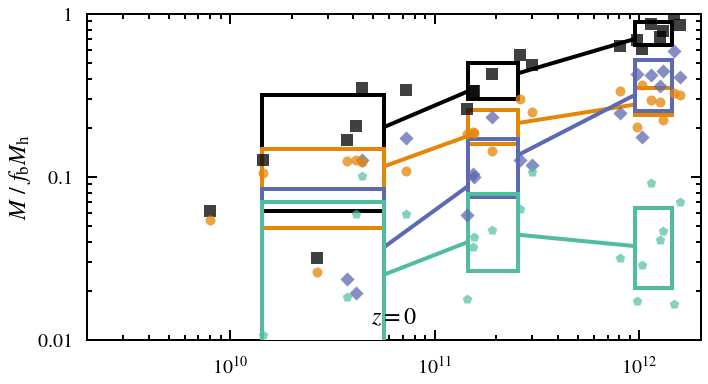

In [24]:
mass_budget_plot(
    include_legend = snum == 465,
    y_range = [ 1e-2, 1 ], 
    save_file_tag = '_v2',
    **mass_budget_kwargs[snum]
)

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/mass_budget_snum600.pdf


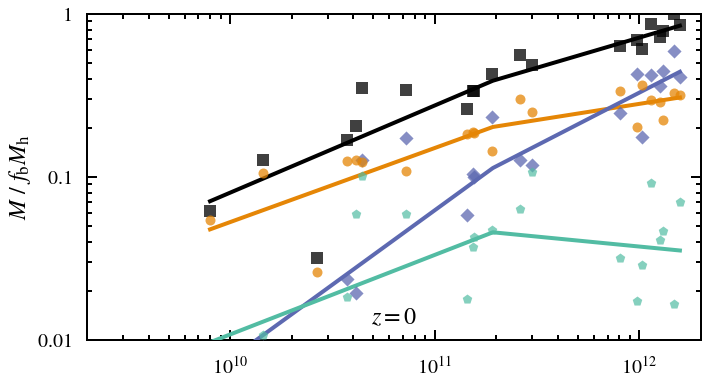

In [25]:
mass_budget_plot(
    include_legend = snum == 465,
    y_range = [ 1e-2, 1 ], 
    plot_box_lines_only = True,
    **mass_budget_kwargs[snum]
)

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/mass_budget_snum600_md_comp.pdf


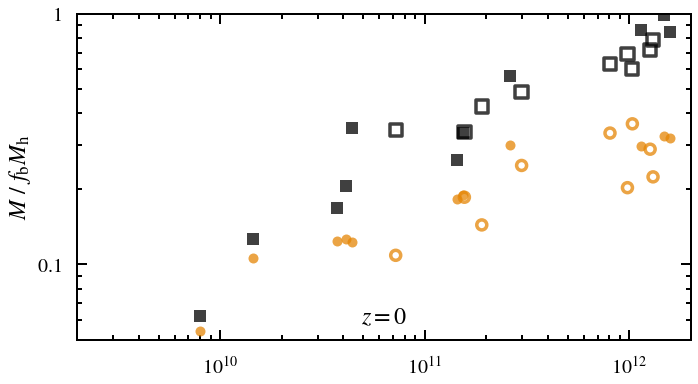

In [26]:
# Appendix metal diffusion plot
mass_budget_plot(
    include_legend = snum == 465,
    y_range = [ 5e-2, 1 ],
    box_plot = False,
    plot_box_lines_only = True,
    categories = [ 'm_halo', 'm_cgm' ],
    md_split_categories = [ 'm_halo', 'm_cgm' ],
    save_file_tag = '_md_comp',
    save_in_figure_dir = True,
    use_minor_tick_formatter = False,
    **mass_budget_kwargs[snum]
)

## Yields Plot

In [27]:
y_boxes = all_results['enriched_metal_mass']['total']['m_budget_halo'] / all_results['M']['stars']['m_gal']

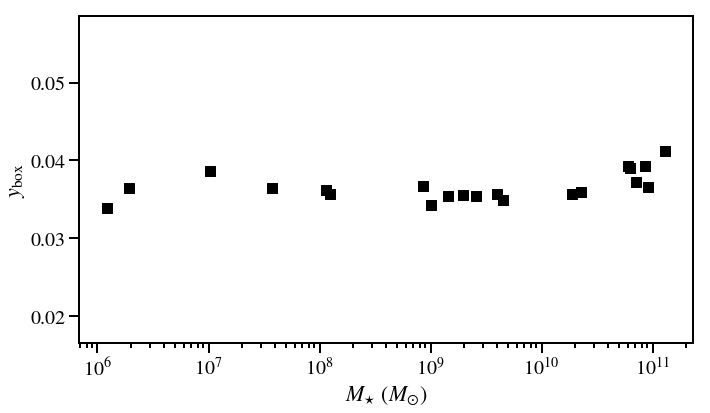

In [28]:
fig = plt.figure( figsize=(11,6) )
ax = plt.gca()

# Total
ax.scatter(
    all_results['M']['stars']['m_gal'].array(),
    y_boxes.array(),
    s = 100,
    color = 'k',
    marker = 's',
    label = 'total',
)

ax.set_xlabel( r'$M_{\star}$ ($M_{\odot}$)', fontsize=22 )
ax.set_ylabel( r'$y_{\rm box}$', fontsize=22 )

ax.set_xscale( 'log' )

## Metal Budget Plot

In [29]:
# Get Peeples+14 data
m_star = np.logspace( 9., 11.4, 256 )
m_halo = 10.**galaxy_trends.smhm_m_halo( np.log10( m_star ), z=redshift )

m_z = galaxy_trends.galaxy_metal_mass( 
    m_star, 
    z_sun = 0.0153,
#     apply_stellar_z_correction = False,
    mass_sources = [ 'stars', 'ISM', 'dust' ],
    use_powerlaw_median_for_cold_gas = True,
    cold_gas_correction_factor = 2.,
)
m_budget = galaxy_trends.galaxy_available_metals(
    m_star,
    alpha = 1.,
    y = y_boxes.array().mean(),
)
m_budget_peeples = galaxy_trends.galaxy_available_metals(
    m_star,
)

In [30]:
metal_budget_kwargs = {
    465: {
        'redshift_coords' : ( 0.05, 0.95 ),
        'redshift_ha' : 'left',
    },
    172 : {
        'redshift_coords' : ( 0.95, 0.05 ),
        'redshift_ha' : 'right',
        'redshift_va' : 'bottom',
    },
    600: {},
}

File saved at /work/03057/zhafen/extra_plots/CGM_origin/metal_mass_budget_snum600_v2.pdf


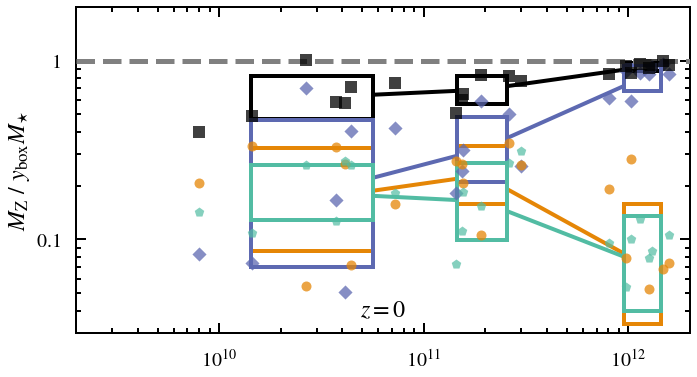

In [31]:
fig = plt.figure( figsize=(11,6) )
ax = plt.gca()

if snum == 465:
    ax.plot(
        m_halo,
        m_z['total'][50] / m_budget,
        linewidth = 5,
        color = colors['m_gal'],
        linestyle = '--',
        zorder = 300,
        label = 'Peeples et al., 2014',
    )
    
    
if snum == 465:
    l = ax.legend(
        prop={'size': 18},
        loc = 'upper center',
    )
    
    ax.add_artist( l )    

mass_budget_plot(
    y_data_type = 'metal_mass',
    fig_and_ax = ( fig, ax ),
    include_legend = snum == 465,
    y_range = [ 3e-2, 2 ],
#     enforce_lower_limit = True,
#     lower_limit = 6e-2,
    hline = 1,
#     box_plot = False,
    save_file_tag = '_v2',
    **metal_budget_kwargs[snum]
)

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/metal_mass_budget_snum600.pdf


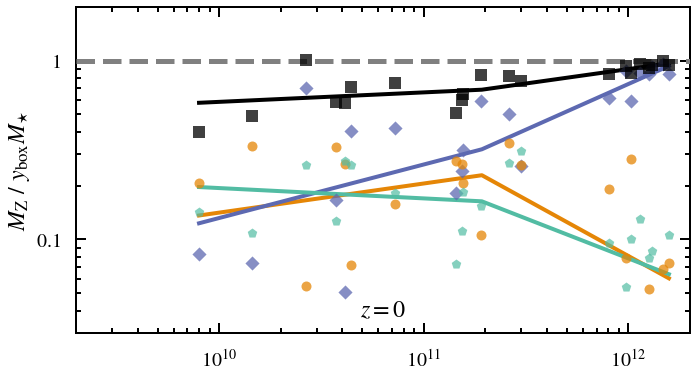

In [32]:
fig = plt.figure( figsize=(11,6) )
ax = plt.gca()

if snum == 465:
    ax.plot(
        m_halo,
        m_z['total'][50] / m_budget_peeples,
        linewidth = 4,
        color = colors['m_gal'],
        linestyle = '--',
        zorder = 300,
        label = 'Peeples et al., 2014',
    )
    
    
if snum == 465:
    l = ax.legend(
        prop={'size': 18},
        loc='upper center',
    )
    
    ax.add_artist( l )    

mass_budget_plot(
    y_data_type = 'metal_mass',
    fig_and_ax = ( fig, ax ),
    include_legend = snum == 465,
    y_range = [ 3e-2, 2 ],
    hline = 1,
    plot_box_lines_only = True,
    **metal_budget_kwargs[snum]
)

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/metal_mass_budget_snum600_md_comp.pdf


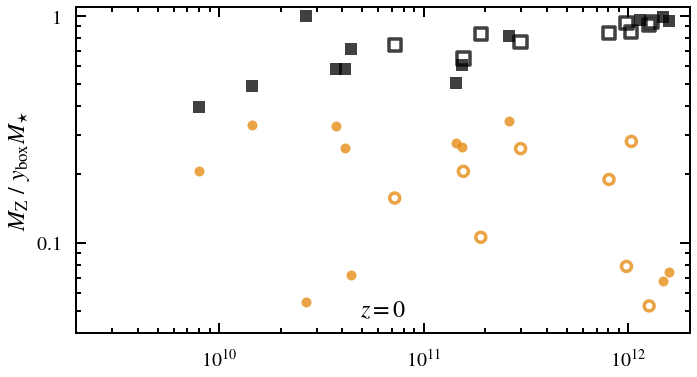

In [33]:
# Appendix metal diffusion difference plot
mass_budget_plot(
    y_data_type = 'metal_mass',
    include_legend = snum == 465,
    y_range = [ 4e-2, 1.1 ],
    box_plot = False,
    categories = [ 'm_halo', 'm_cgm' ],
    md_split_categories = [ 'm_halo', 'm_cgm' ],
    save_file_tag = '_md_comp',
    save_in_figure_dir = True,
    use_minor_tick_formatter = False,
    **metal_budget_kwargs[snum]
)

#### Appendix Plot

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/metal_mass_budget_snum600_comp.pdf


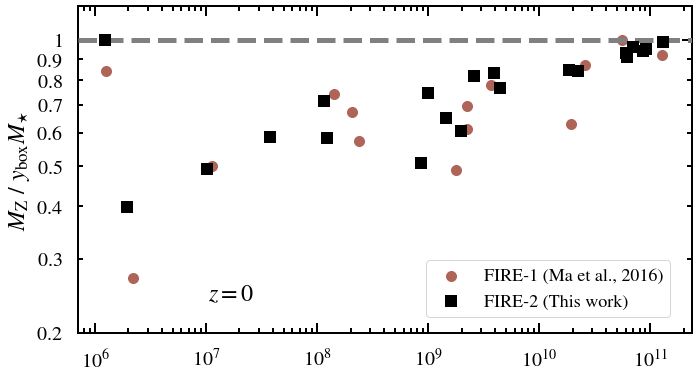

In [84]:
if snum == 600:

    fig = plt.figure( figsize=(11,6) )
    ax = plt.gca()   

    m_star_f1, m_halo_f1 = galaxy_trends.halo_metal_budget()
    ax.scatter(
        m_star_f1,
        m_halo_f1,
        color = palettable.cartocolors.qualitative.Antique_3.mpl_colors[-1],
        s = 100,
        label = 'FIRE-1 (Ma et al., 2016)',
    )

    mass_budget_plot(
        x_data_type = 'm_star',
        y_data_type = 'metal_mass',
        fig_and_ax = ( fig, ax ),
        include_legend = True,
        categories = [ 'm_halo' ],
        redshift_coords = (0.25, 0.15 ),
        hline = 1,
        box_plot = False,
        y_range = [ 0.2, 1.2 ],
        point_alpha = 1.,
        x_label = False,
        custom_legend_kwargs = {
            'prop' : {'size': 18},
            'loc' : 'lower right',
            'bbox_to_anchor' : ( 0.98, 0.02 ),
        },
        overriding_label = 'FIRE-2 (This work)',
        save_file_tag = '_comp',
        save_in_figure_dir = True,
        use_minor_tick_formatter = True,
    )

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/cgm_met_comparison_snum600.pdf


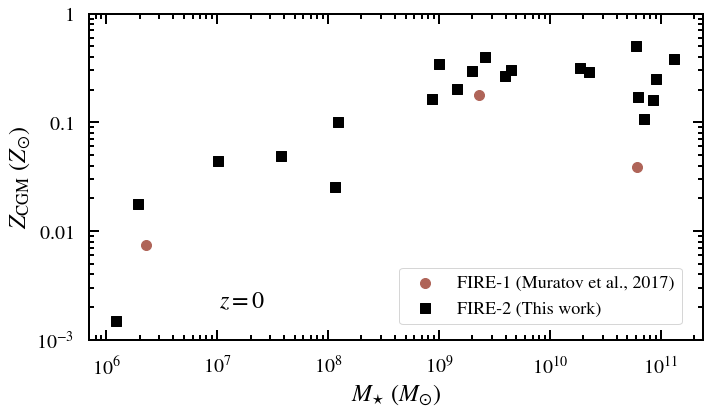

In [82]:
if snum == 600:

    fig = plt.figure( figsize=(11,6) )
    ax = plt.gca()   
    
    # FIRE-1 metallicities
    m_star_f1 = [ 2.3e6, 2.3e9, 6.1e10 ]
    met_cgm_f1 = np.array( [ 5e-3, 0.12, 2.6e-2 ] ) * 0.02 / 0.0134
    ax.scatter(
        m_star_f1,
        met_cgm_f1,
        color = palettable.cartocolors.qualitative.Antique_3.mpl_colors[-1],
        s = 100,
        label = 'FIRE-1 (Muratov et al., 2017)',
    )
    
    # FIRE-2 metallicities
    m_star_f2 = all_results['M']['stars']['m_gal'].array()
    met_cgm_f2 = (
        all_results['enriched_metal_mass']['gas']['m_cgm'] /
        all_results['M']['gas']['m_cgm']
    ).array() / 0.0134
    ax.scatter(
        m_star_f2,
        met_cgm_f2,
        color = 'k',
        s = 100,
        marker = 's',
        label = 'FIRE-2 (This work)',
    )
    
    ax.set_xlabel( r'$M_{\star}$ ($M_{\odot}$)', fontsize=24 )
    ax.set_ylabel( r'$Z_{\rm CGM}$ ($Z_{\odot}$)', fontsize=24 )
    
    ax.set_xscale( 'log' )
    ax.set_yscale( 'log' )

    # Use better log formatter
    log_ticker = matplotlib.ticker.FuncFormatter( generic_plotting.custom_log_formatter )
    ax.yaxis.set_major_formatter( log_ticker )
#     ax.yaxis.set_minor_formatter( log_ticker )


    # Ranges
    ax.set_xlim( 7e5, 2.4e11 )
    ax.set_ylim( 1e-3, 1 )
        
    # Annotate redshift
    ax.annotate(
        s = r'$z=' + '{:.2g}'.format( redshift ) + '$',
        xy = (0.25, 0.15 ),
        xycoords = 'axes fraction', 
        fontsize = 24,
        ha = 'center',
        va = 'top',
        zorder = 250,
    )
        
    # Fidget with parameters
    ax.tick_params( right=True, top=True, which='both', direction='in', zorder=1000, pad=15 )
    
    ax.legend(
        prop = {'size': 18},
        loc = 'lower right',
        bbox_to_anchor = ( 0.98, 0.02 ),
    )

    save_file = 'cgm_met_comparison_snum{}.pdf'.format( snum, )
    out_dir = file_manager.get_project_figure_dir()

    generic_plotting.save_fig(
        out_dir = out_dir,
        save_file = save_file,
        fig = fig,
    )

File saved at /work/03057/zhafen/extra_plots/CGM_origin/metal_mass_budget_snum600_comp.pdf


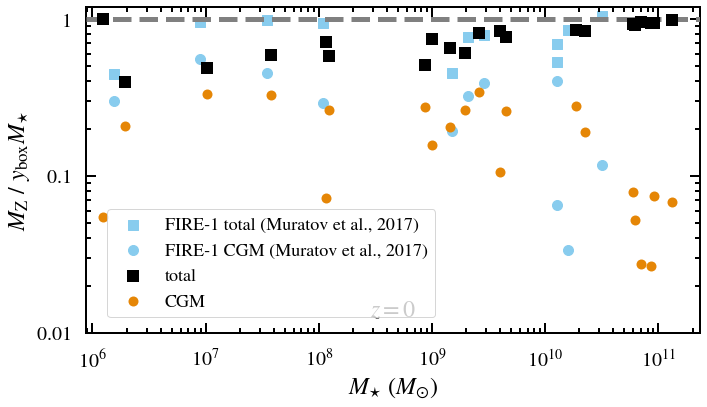

In [35]:
fig = plt.figure( figsize=(11,6) )
ax = plt.gca()

m_star_f1, m_halo_f1 = galaxy_trends.halo_metal_budget()
# ax.scatter(
#     m_star_f1,
#     m_halo_f1,
#     color = palettable.cartocolors.qualitative.Antique_3.mpl_colors[-1],
#     marker = 's',
#     s = 100,
#     label = 'FIRE-1 (Ma et al., 2016)',
# )

m_star_f1, m_halo_f1 = galaxy_trends.halo_metal_budget(
    data = 'MzMstar_Muratov2017.csv',
    log_mstar = True,
)
m_star_f1, m_gal_f1 = galaxy_trends.halo_metal_budget(
    data = 'MzgalMstar_Muratov2017.csv',
    log_mstar = True,
)
m_cgm_f1 = m_halo_f1 - m_gal_f1
ax.scatter(
    m_star_f1,
    m_halo_f1,
    color = palettable.cartocolors.qualitative.Safe_3.mpl_colors[0],
    marker = 's',
    s = 100,
    label = 'FIRE-1 total (Muratov et al., 2017)',
)
ax.scatter(
    m_star_f1,
    m_cgm_f1,
    color = palettable.cartocolors.qualitative.Safe_3.mpl_colors[0],
    s = 100,
    label = 'FIRE-1 CGM (Muratov et al., 2017)',
)

mass_budget_plot(
    x_data_type = 'm_star',
    y_data_type = 'metal_mass',
    fig_and_ax = ( fig, ax ),
    include_legend = True,
    categories = [ 'm_halo', 'm_cgm' ],
    redshift_coords = (0.5, 0.1 ),
    hline = 1,
    box_plot = False,
    y_range = [ 1e-2, 1.2 ],
    point_alpha = 1.,
    x_label = True,
    custom_legend_kwargs = {
        'prop' : {'size': 18},
        'loc' : 'lower left',
        'bbox_to_anchor' : ( 0.02, 0.02 ),
    },
#     overriding_label = 'FIRE-2 (This work)',
    save_file_tag = '_comp',
    save_in_figure_dir = False,
#     use_minor_tick_formatter = True,
)

File saved at /home1/03057/zhafen/papers/CGM_origin/figures/phase_cgm_mass_budget_snum600.pdf


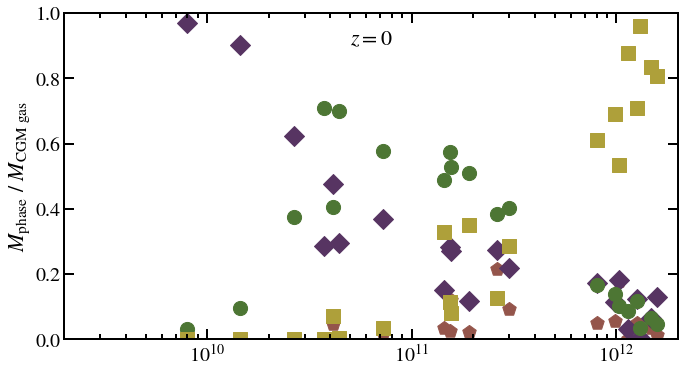

In [36]:
fig = plt.figure( figsize=(11,6) )
ax = plt.gca()

# Total
# ax.scatter(
#     all_results['M']['stars']['m_gal'].array(),
#     all_results['M']['gas']['m_halo'].array()/all_results['M']['total']['m_budget_halo'].array(),
#     s = 200,
#     color = 'k',
#     marker = 's',
#     label = 'total',
# )

x_data = all_results['M']['total']['m_vir'].array()

# Cold
ax.scatter(
    x_data,
    all_results['M']['gas']['m_cold'].array()/all_results['M']['gas']['m_cgm'].array(),
    s = 200,
    color = (209./360, 120./360, 106./360),
    marker = 'p',
    label = r'$T < 10^4$ K',
)

# Cool
ax.scatter(
    x_data,
    all_results['M']['gas']['m_cool'].array()/all_results['M']['gas']['m_cgm'].array(),
    s = 200,
    color = (123./360, 73./360, 139./360),
    marker = 'D',
    label = r'$10^4 < T < 10^{4.7}$ K',
)

# Warm
ax.scatter(
    x_data,
    all_results['M']['gas']['m_warm'].array()/all_results['M']['gas']['m_cgm'].array(),
    s = 200,
    color = (109./360, 166./360, 74./360),
    marker = 'o',
    label = r'$10^{4.7} < T < 10^{5.3}$ K',
)

# Hot
ax.scatter(
    x_data,
    all_results['M']['gas']['m_hot'].array()/all_results['M']['gas']['m_cgm'].array(),
    s = 200,
    color = (245./360, 226./360, 82./360),
    marker = 's',
    label = r'$T > 10^{5.3}$ K',
)

# # Stars
# ax.scatter(
#     all_results['M']['stars']['m_gal'].array(),
#     all_results['M']['stars']['m_halo'].array()/all_results['M']['total']['m_budget_halo'].array(),
#     s = 200,
#     color = 'k',
#     marker = '*',
#     label = 'stars',
# )

# # Other gas
# ax.scatter(
#     all_results['M']['stars']['m_gal'].array(),
#     ( all_results['M']['gas']['m_gal'] + all_results['M']['gas']['m_interface']).array()/all_results['M']['total']['m_budget_halo'].array(),
#     s = 200,
#     color = 'k',
#     marker = '*',
#     label = 'ISM or interface',
# )

ax.annotate(
    s = r'$z=' + '{:.2g}'.format( redshift ) + '$',
    xy = (0.5, 0.95),
    xycoords = 'axes fraction', 
    fontsize = 22,
    ha = 'center',
    va = 'top',
)

ax.tick_params( which='both', direction='in', right=True, top=True )

if snum == 172:
    ax.set_xlabel( r'$M_{\rm h}$ ($M_{\odot}$)', fontsize=22 )
ax.set_ylabel( r'$M_{\rm phase}$ / $M_{\rm CGM\ gas}$', fontsize=22 )

if snum == 465:
    l = ax.legend(
#         bbox_to_anchor = ( 0.5, 1. ),
#         ncol = 4,
        prop={'size': 18},
#         loc = 'lower center',
    )

ax.set_xlim( 2e9, 2e12 )
y_max_mass = 1.0
ax.set_ylim( 0.0, y_max_mass )

ax.set_xscale( 'log' )
# ax.set_yscale( 'log' )

save_file = 'phase_cgm_mass_budget_snum{}.pdf'.format( snum )
generic_plotting.save_fig(
    out_dir = file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
#         resolution = 100,
)

In [37]:
total = np.zeros( all_results['M']['gas']['m_cgm'].array().shape )
for phase_key in ['cold', 'cool', 'warm', 'hot' ]:
    total += all_results['M']['gas']['m_{}'.format( phase_key )].array()/all_results['M']['gas']['m_cgm'].array()

### Gas Fractions

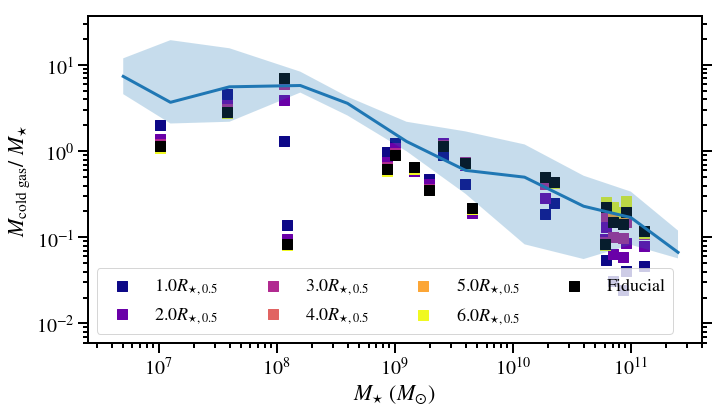

In [38]:
fig = plt.figure(  figsize=(11,6) )
ax = plt.gca()

x_data = all_results['M']['stars']['m_gal'].array()

# Different choices of R_gal
for i, cut in enumerate( [ 1.0, 2.0, 3.0, 4.0, 5.0, 6.0 ] ):
    
    try:
        gas_fractions = (
            all_results['M']['gas']['dense_{}'.format(cut)] /
            all_results['M']['stars']['{}'.format(cut)]
        )
    except KeyError:
        gas_fractions = (
            all_results['M']['gas']['dense_{}'.format(cut)] /
            all_results['M']['stars'][cut]
        )
    
    ax.scatter(        
    x_data,
    gas_fractions.array(),
    s = 100,
    marker = 's',
    color = palettable.matplotlib.Plasma_6.mpl_colors[i],
    label = r'{}'.format( cut ) + r'$R_{\star,0.5}$',
)

# Fiducial
gas_fractions = all_results['M']['gas']['m_gal'] / all_results['M']['stars']['m_gal']
ax.scatter(
    x_data,
    gas_fractions.array(),
    s = 100,
    marker = 's',
    color = 'k',
    label = r'Fiducial',
)

m_star_trend, obs_gas_fraction = galaxy_trends.cold_gas_fraction( None, False )    
ax.plot(
    m_star_trend,
    obs_gas_fraction[50],
    linewidth = 3
)
ax.fill_between(
    m_star_trend,
    obs_gas_fraction[16],
    obs_gas_fraction[84],
    linewidth = 3,
    alpha = 0.25,
)


ax.set_xscale( 'log' )
ax.set_yscale( 'log' )

ax.set_xlabel( r'$M_{\star}$ ($M_{\odot}$)', fontsize=22 )
ax.set_ylabel( r'$M_{\rm cold\ gas}$/ $M_{\star}$', fontsize=22 )

ax.set_xlim( 10.**6.4, 10.**11.6 )

ax.tick_params( right=True, which='both' )

l = ax.legend(
#         bbox_to_anchor = ( 0.5, 1. ),
        ncol = 4,
    prop={'size': 18},
#         loc = 'lower center',
)


In [39]:
gas_fractions = all_results['M']['gas']['m_gal'] / all_results['M']['stars']['m_gal']

In [40]:
gas_fraction_m12 = np.median( gas_fractions.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )
gas_fraction_m12

0.17201590335367203

In [41]:
obs_gas_fraction[50][-3]

0.23

In [42]:
gas_fraction_m12 / obs_gas_fraction[50][-3]

0.7478952319724871

## Mass-Metallicity Relation

### Stars

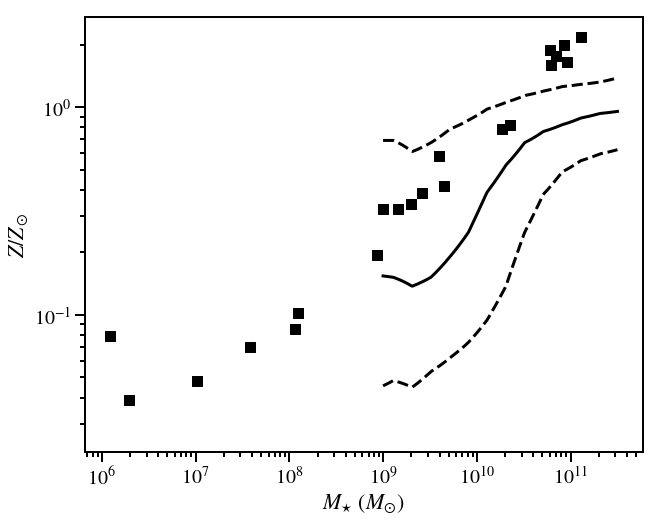

In [43]:
fig = plt.figure( figsize=(10,8), facecolor='white' )
ax = plt.gca()

x_data = all_results['M']['stars']['m_gal']
z_sun = 0.0153
y_data = ( all_results['enriched_metal_mass']['stars']['m_gal'] / all_results['M']['stars']['m_gal'] ) / z_sun
ax.scatter(
    x_data.array(),
    y_data.array(),
    s = 100,
    marker = 's',
    color = 'k',
    label = r'Fiducial',
)

m_star = np.logspace( 9., 11.5, 256 )
z_star = galaxy_trends.stellar_mass_metallicity_relation( m_star, True )

ax.plot(
    m_star,
    z_star[50],
    color = 'k',
    linewidth = 3,
)

for p in [ 16, 84 ]:
    ax.plot(
        m_star,
        z_star[p],
        color = 'k',
        linewidth = 3,
        linestyle = '--',
    )

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )


ax.set_xlabel( r'$M_{\star}$ ($M_{\odot}$)', fontsize=22 )
ax.set_ylabel( r'$Z / Z_\odot$', fontsize=22 )

### Gas

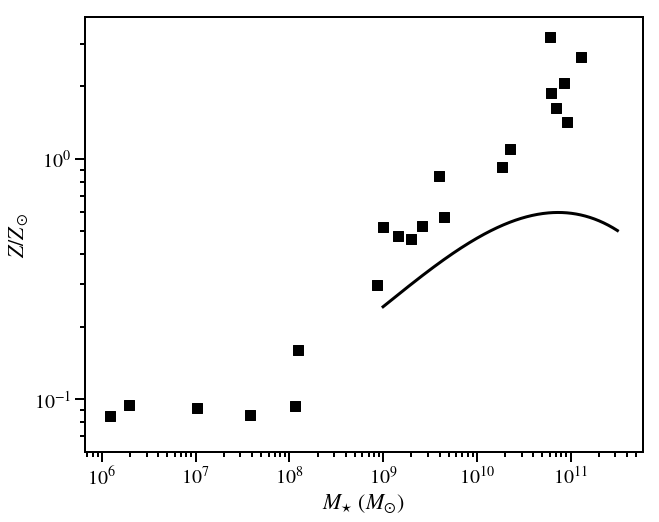

In [44]:
fig = plt.figure( figsize=(10,8), facecolor='white' )
ax = plt.gca()

x_data = all_results['M']['stars']['m_gal']
z_sun = 0.02
y_data = ( all_results['enriched_metal_mass']['gas']['m_gal'] / all_results['M']['gas']['m_gal'] ) / z_sun
ax.scatter(
    x_data.array(),
    y_data.array(),
    s = 100,
    marker = 's',
    color = 'k',
    label = r'Fiducial',
)

m_star = np.logspace( 9., 11.5, 256 )
z_sun_obs = 0.0153
z_ism = galaxy_trends.ism_mass_metallicity_relation( m_star, 0.0153 ) / z_sun_obs

ax.plot(
    m_star,
    z_ism,
    color = 'k',
    linewidth = 3,
)

ax.set_xscale( 'log' )
ax.set_yscale( 'log' )


ax.set_xlabel( r'$M_{\star}$ ($M_{\odot}$)', fontsize=22 )
ax.set_ylabel( r'$Z / Z_\odot$', fontsize=22 )

In [45]:
med_m12_mstar = np.median( x_data.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )

In [46]:
mzr_m12 = np.median( y_data.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )
mzr_m12

1.7500857006853912

In [47]:
obs_mzr_m12 = z_ism[np.abs(np.log10(m_star) - np.log10( med_m12_mstar ) )<0.001]
obs_mzr_m12

array([], dtype=float64)

In [48]:
mzr_m12 / obs_mzr_m12

array([], dtype=float64)

### More About Metals in the Galaxy

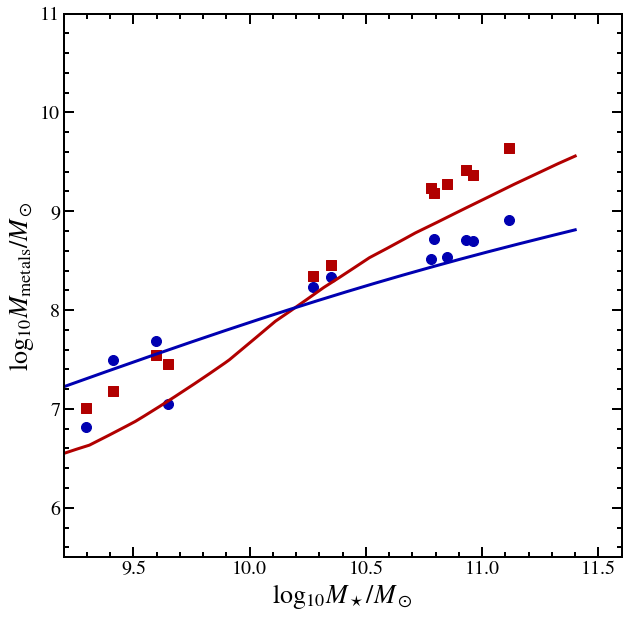

In [49]:
fig = plt.figure( figsize=(10,10), facecolor='white' )
ax = plt.gca()

x_data = all_results['M']['stars']['m_gal']

m_star = np.logspace( 9., 11.4, 256 )
# m_star = 1e10
m_z = galaxy_trends.galaxy_metal_mass( 
    m_star, 
    z_sun = 0.0153,
    apply_stellar_z_correction = True,
    mass_sources = [ 'stars', 'ISM', 'dust' ],
    use_powerlaw_median_for_cold_gas = True,
    cold_gas_correction_factor = 2.,
)

metal_colors = {
    'total' : 'k',
    'stars' : [ 250./360, 0, 0 ],
    'ISM' : [ 0, 0, 250./360 ],
    'dust' : [ 250/360., 250./360, 0. ],
}
    
# Plot Stellar Metals
ax.plot(
    np.log10( m_star ),
    np.log10( m_z['stars'][50] ),
    color = metal_colors['stars'],
    linewidth = 3,
)
stellar_metals = all_results['enriched_metal_mass']['stars']['m_gal']
ax.scatter(
    x_data.log10().array(),
    stellar_metals.log10().array(),
    s = 100,
    marker = 's',
    color = metal_colors['stars'],
    label = r'Fiducial',
)

# Plot stellar plus gas metals
ax.plot(
    np.log10( m_star ),
    np.log10( m_z['ISM'][50] + m_z['dust'][50] ),
    color = metal_colors['ISM'],
    linewidth = 3,
)
gas_metals = all_results['enriched_metal_mass']['gas']['m_gal']
ax.scatter(
    x_data.log10().array(),
    gas_metals.log10().array(),
    s = 100,
    marker = 'o',
    color = metal_colors['ISM'],
    label = r'Fiducial',
)

#     for p in [ 16, 84 ]:
#         ax.plot(
#             np.log10( m_star ),
#             np.log10( item[p] ),
#             color = metal_colors[key],
#             linewidth = 3,
#             linestyle = ':',
#         )

#     ax.fill_between(
#         np.log10( m_star ),
#         np.log10( item[16] ),
#         np.log10( item[84] ),
#         color = colors[key],
#         alpha = 0.2,
#     )
    

# # Metals available according to digitized Peeples+14
# ax.plot(
#     np.log10( m_star ),
#     np.log10( galaxy_trends.galaxy_available_metals( m_star, ) ),
#     linewidth  = 3,
#     color = 'k',
# )

# Limits
ax.set_xlim(9.2, 11.6)
ax.set_ylim(5.5, 11.)

# Setup minor ticks
ml_x = matplotlib.ticker.MultipleLocator( 0.1 )
ax.xaxis.set_minor_locator( ml_x )
ml_y = matplotlib.ticker.MultipleLocator( 0.2 )
ax.yaxis.set_minor_locator( ml_y )

# Labels
ax.set_xlabel( r'$\log_{10} M_\star/M_\odot$', fontsize=26)
ax.set_ylabel( r'$\log_{10} M_{\rm metals}/M_\odot$', fontsize=26)

ax.tick_params( which='both', direction='in', right=True, top=True )

# Analysis

In [50]:
import os

import py2tex.py2tex as py2tex

In [51]:
tex_filepath = os.path.join( file_manager.project_parameters['project_dir'], 'variables.tex' )

In [52]:
tex_file = py2tex.TeXVariableFile( tex_filepath )

In [53]:
# Used for variable names
if snum == 465:
    regime = 'low'
if snum == 172:
    regime = 'high'

### Check that everything adds up

In [54]:
def check_masses_add_up( mass_key ):
    gal_mass_frac = all_results[mass_key]['total']['m_gal']/all_results[mass_key]['total']['m_halo']

    cgm_mass_frac = all_results[mass_key]['total']['m_cgm']/all_results[mass_key]['total']['m_halo']

    interface_mass_frac = all_results[mass_key]['total']['m_interface']/all_results[mass_key]['total']['m_halo']

    total = gal_mass_frac + cgm_mass_frac + interface_mass_frac

    np.testing.assert_allclose( total.array(), np.ones( total.array().size ), rtol=1e-2 )

In [55]:
check_masses_add_up( 'M' )

In [56]:
check_masses_add_up( 'enriched_metal_mass' )

### Outliers

#### Low stellar mass outlier

In [57]:
if 'm10v' in sim_names:
    tex_file.save_variable(
        'mtenvmstar{}'.format( regime ),
        py2tex.to_tex_scientific_notation( all_results['M']['stars']['m_gal']['m10v'], 1 )
    )

    m10_met = all_results['enriched_metal_mass']['total']['m_halo']['m10v'] / all_results['enriched_metal_mass']['total']['m_budget_halo']['m10v']
    tex_file.save_variable(
        'mtenvmz{}'.format( regime ),
        '{:.1g}'.format( m10_met ),
    )

NameError: name 'regime' is not defined

### Peek at the box yields

In [ ]:
tex_file.save_variable(
    'ybox{}'.format( regime ),
    '{:.2g}'.format( y_boxes.array().mean() ),
)

In [ ]:
tex_file.save_variable(
    'yboxstd{}'.format( regime ),
    '{:.1g}'.format( y_boxes.array().std() ),
)

In [ ]:
if 'm10v' in sim_names:
    tex_file.save_variable(
        'yboxmtenv{}'.format( regime ),
        '{:.2g}'.format( y_boxes['m10v'] ),
    )

### How much mass does the metal floor make up?

In [ ]:
m_floor_frac = all_results['enriched_metal_mass']['total']['m_floor'] / ( all_results['enriched_metal_mass']['total']['m_halo'] + all_results['enriched_metal_mass']['total']['m_floor'] )

In [ ]:
m_floor_frac.keymax()

In [ ]:
tex_file.save_variable(
    'floormetalmassmax{}'.format( regime ),
    py2tex.to_tex_percentage( m_floor_frac.keymax()[1] ),
)

### How much mass do stars inside the galaxy-halo interface contribute?

In [ ]:
stellar_mass_in_rcgm = all_results['M']['stars']['m_gal'] + all_results['M']['stars']['m_interface']

In [ ]:
mean_stellar_fraction_in_gap = ( all_results['M']['stars']['m_interface'] / stellar_mass_in_rcgm ).array().mean()

In [ ]:
tex_file.save_variable(
    'meanstellarpercentingap{}'.format( regime ),
    py2tex.to_tex_percentage( mean_stellar_fraction_in_gap ),
)

In [ ]:
mean_stellar_mass_frac_in_gap = ( all_results['M']['stars']['m_interface'] /
    ( all_results['M']['stars']['m_interface']
    + all_results['M']['gas']['m_interface'] ) ).array().mean()

In [ ]:
tex_file.save_variable(
    'meanstellarmasspercentingap{}'.format( regime ),
    py2tex.to_tex_percentage( mean_stellar_mass_frac_in_gap ),
)

### How much dense mass is in the CGM?

In [ ]:
med_dense_CGM_mass = np.median( ( all_results['M']['gas']['m_dense_cgm'] / all_results['M']['gas']['m_cgm'] ).array() )

In [ ]:
( all_results['M']['gas']['m_dense_cgm'] / all_results['M']['gas']['m_cgm'] )

In [ ]:
tex_file.save_variable(
    'meddenseCGMmass{}'.format( regime ),
    py2tex.to_tex_percentage( med_dense_CGM_mass ),
)

### How much dense mass is in the galaxy-halo interface?

In [ ]:
dense_fraction = all_results['M']['gas']['m_dense_interface'] / all_results['M']['gas']['m_interface']

In [ ]:
tex_file.save_variable(
    'meddenseinterfacemass{}'.format( regime ),
    py2tex.to_tex_percentage( np.median( dense_fraction.array() ) ),
)

In [ ]:
tex_file.save_variable(
    'maxdenseinterfacemass{}'.format( regime ),
    py2tex.to_tex_percentage( dense_fraction.keymax()[1] ),
)

In [ ]:
dense_frac_max_radius_ratio = ( all_results['R']['r_gal'] / ( 0.1 * all_results['R']['r_vir'] ) )[dense_fraction.keymax()[0]]

In [ ]:
tex_file.save_variable(
    'maxdenseinterfaceradiusratio{}'.format( regime ),
    py2tex.to_tex_percentage( dense_frac_max_radius_ratio ),
)

### How many split particles are in the CGM?

In [ ]:
n_split_particles = (
    all_results['M']['gas']['n_particles_cgm'] -
    all_results['M']['gas']['n_unique_particles_cgm']
)
# To account for the fact that particles split in pairs
n_split_particles *= 2.
fraction_split = n_split_particles / all_results['M']['gas']['n_particles_cgm']
fraction_split

In [ ]:
tex_file.save_variable(
    'maxpercentsplitCGM{}'.format( regime ),
    '{:.1g}'.format( fraction_split.array().max()*100, ),
)

### What is the mass and metal mass for simulations with/without metal diffusion?

In [ ]:
def split_md( dict_to_split ):
    
    results = {
        'md' : verdict.Dict( {} ),
        'core' : verdict.Dict( {} ),
    }
    for key, item in dict_to_split.items():
        
        if key[-3:] == '_md':
            results['md'][key] = item
        else:
            results['core'][key] = item
    
    return results            

In [ ]:
m12s = all_results['M']['stars']['m_gal'].split_by_dict( 
    linefinder_config.MASS_BINS
)['m12']

In [ ]:
for physics_type in [ 'core', 'md' ]:
    tex_file.save_variable(
        'meanmstar{}MW{}'.format( physics_type, regime ),
        py2tex.to_tex_scientific_notation( split_md( m12s )[physics_type].array().mean(), 1 ),
    )

In [ ]:
m12s_halo = all_results['M']['total']['m_vir'].split_by_dict( 
    linefinder_config.MASS_BINS
)['m12']

In [ ]:
for physics_type in [ 'core', 'md' ]:
    tex_file.save_variable(
        'meanmh{}MW{}'.format( physics_type, regime ),
        py2tex.to_tex_scientific_notation( split_md( m12s_halo )[physics_type].array().mean(), 1 ),
    )

### Look at masses in different bins

#### Stellar Masses

In [ ]:
sub_stellar = all_results['M']['stars']['m_gal'].split_by_dict( linefinder_config.MASS_BINS )

In [ ]:
for key, item in sub_stellar.items():
    print( item.log10().array().mean() )

#### Mass budget

In [ ]:
mass_budget = all_results['M']['total']['m_budget_halo'].split_by_dict( linefinder_config.MASS_BINS )

#### Total Mass

In [ ]:
total_mass = all_results['M']['total']['m_halo'].split_by_dict( linefinder_config.MASS_BINS )

In [ ]:
for mass_bin, name in zip( [ 'm10', 'm11', 'm12' ], ['dwarf', 'subMW', 'MW' ] ):
    tex_file.save_variable(
        'fbaryon{}mean{}'.format( name, regime ),
        '{:.1g}'.format( ( total_mass[mass_bin] / mass_budget[mass_bin] ).array().mean() ),
    )

#### Mass in different categories

In [ ]:
for mass_category, mass_category_name in zip( ['m_cgm', 'm_gal', 'm_interface' ], [ 'CGM', 'galaxy', 'interface'] ):

    category_ptype = category_ptypes[mass_category]
    
    mass = all_results['M'][category_ptype][mass_category].split_by_dict( linefinder_config.MASS_BINS )

    for mass_bin, name in zip( [ 'm10', 'm11', 'm12' ], ['dwarf', 'subMW', 'MW' ] ):

        value = mass[mass_bin].array().mean()
        tex_file.save_variable(
            'totmass{}{}mean{}'.format( mass_category_name, name, regime ),
            py2tex.to_tex_scientific_notation( value ),
        )    

        value = ( mass[mass_bin] / total_mass[mass_bin] ).array().mean()
        tex_file.save_variable(
            'f{}{}mean{}'.format( mass_category_name, name, regime ),
            py2tex.to_tex_percentage( value, 5, False, nearest_base=True ),
        )

In [ ]:
# What is the median mass contributed by the interface?
med_interface = np.median( (
        all_results['M']['gas']['m_interface'] / all_results['M']['total']['m_halo']
    ).array() )

tex_file.save_variable(
    'finterfacemedian{}'.format( regime ),
    py2tex.to_tex_percentage( value, 5, True, nearest_base=True ),
)

### Look at metal masses in different bins

#### Mass budget

In [ ]:
mass_budget = all_results['enriched_metal_mass']['total']['m_budget_halo'].split_by_dict( linefinder_config.MASS_BINS )

#### Total Mass

In [ ]:
total_mass = all_results['enriched_metal_mass']['total']['m_halo'].split_by_dict( linefinder_config.MASS_BINS )

In [ ]:
for mass_bin, name in zip( [ 'm10', 'm11', 'm12' ], ['dwarf', 'subMW', 'MW' ] ):
    tex_file.save_variable(
        'fmetal{}mean{}'.format( name, regime ),
        '{:.1g}'.format( ( total_mass[mass_bin] / mass_budget[mass_bin] ).array().mean() ),
    )

#### Mass in different categories

In [ ]:
for mass_category, mass_category_name in zip( ['m_cgm', 'm_gal', 'm_interface' ], [ 'CGM', 'galaxy', 'interface'] ):

    category_ptype = category_ptypes[mass_category]
    
    mass = all_results['enriched_metal_mass'][category_ptype][mass_category].split_by_dict( linefinder_config.MASS_BINS )

    for mass_bin, name in zip( [ 'm10', 'm11', 'm12' ], ['dwarf', 'subMW', 'MW' ] ):

        value = mass[mass_bin].array().mean()
        tex_file.save_variable(
            'totmetmass{}{}mean{}'.format( mass_category_name, name, regime ),
            py2tex.to_tex_scientific_notation( value ),
        )    

        value = ( mass[mass_bin] / total_mass[mass_bin] ).array().mean()
        tex_file.save_variable(
            'fmet{}{}mean{}'.format( mass_category_name, name, regime ),
            py2tex.to_tex_percentage( value, 5, False, nearest_base=True ),
        )

## Comparison to Peeples+14 Metal Mass

In [ ]:
med_m12_mstar = np.median( x_data.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )

#### How do our fractions of metals retained compare to Peeples?

In [ ]:
if snum == 465:
    met_budget = all_results['enriched_metal_mass']['total']['m_gal'] / all_results['enriched_metal_mass']['total']['m_budget_halo']

    met_budget_m12 = np.median( met_budget.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )
    met_budget_m12

    met_budget_m12_p14 = (m_z['total'][50] / m_budget_peeples)[np.abs(np.log10(m_halo)-12)<0.005][0]
    met_budget_m12_p14

    tex_file.save_variable(
        'fretdivfretPeeples',
        '{:.2g}'.format( met_budget_m12 / met_budget_m12_p14 ),
    )

### Reasons for Differences with Peeples+14
1. Yields + IMF (Kroupa vs Chabrier) (~1.9)
3. Feedback
4. Stellar light correction factor (~1.2)
5. Solar metallicity assumption (~1.3)
6. Gas fractions (~negligible: our median gas fraction is higher by ~1.25 but we overestimate the observed metal masses by similar amounts)

#### Metal Budget Differences

In [ ]:
budget_difference =  ( 0.36 * 1e11 ) / ( 0.48 * 1e11**1.014 )
budget_difference

In [ ]:
if snum == 465:
    tex_file.save_variable(
        'metbudgdivmetbudgPeeples',
        '{:.2g}'.format( budget_difference ),
    )

#### Metal Mass Differences

##### Total Differences

In [ ]:
if snum == 465:

    metal_masses = all_results['enriched_metal_mass']['total']['m_gal']

    med_met_m12 = np.median( metal_masses.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )

    obs_met_m12 = m_z['total'][50][np.abs(np.log10(m_star) - np.log10(med_m12_mstar) )< 0.001][0]

    tex_file.save_variable(
        'metmassdivmetmassPeeples',
        '{:.2g}'.format( med_met_m12 / obs_met_m12 ),
    )

##### Individual Categories

In [ ]:
met_star_m12 = np.median( stellar_metals.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )
met_star_m12

In [ ]:
obs_met_star_m12 = m_z['stars'][50][np.abs(np.log10(m_star) - np.log10(med_m12_mstar) )< 0.001]
obs_met_star_m12

In [ ]:
met_star_m12 / obs_met_star_m12

In [ ]:
met_gas_m12 = np.median( gas_metals.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )
met_gas_m12

In [ ]:
obs_met_gas_m12 = ( m_z['ISM'][50] + m_z['dust'][50] )[np.abs(np.log10(m_star) - np.log10(med_m12_mstar) )< 0.001]
obs_met_gas_m12

In [ ]:
met_gas_m12 / obs_met_gas_m12

#### Stellar MZR Differences

In [ ]:
z_star_corrected = galaxy_trends.stellar_mass_metallicity_relation( med_m12_mstar, True )
z_star_uncorrected = galaxy_trends.stellar_mass_metallicity_relation( med_m12_mstar, False )

In [ ]:
if snum == 465:
    tex_file.save_variable(
        'zstardivzstarcorrected',
        '{:.2g}'.format( ( z_star_uncorrected/z_star_corrected )[50] ),
    )

In [ ]:
0.02/ 0.0153

In [ ]:
mzr_m12 = np.median( y_data.split_by_dict( linefinder_config.MASS_BINS )['m12'].array() )
mzr_m12

In [ ]:
obs_mzr_m12 = z_star[50][np.abs(np.log10(m_star) - np.log10( med_m12_mstar ) )<0.001]
obs_mzr_m12

In [ ]:
mzr_m12 / obs_mzr_m12

In [ ]:
1.3 * 1.2 / 0.5

$M_{Z,F} \approx 1.6 M_{Z,P14}$

$M_{B,F} \approx 0.5 M_{B,P14}$

Therefore, $\frac{M_{Z,F} }{ M_{B,F} } \approx 3 \frac{M_{Z,P14} }{ M_{B,P14} }$

Another way of thinking about this is that $M_{\rm Z} = f_{\rm retained} M_{\rm B}$.
Therefore $f_{\rm retained, F} \approx 3 f_{\rm retained, P14}$.
Even if we have the budget wrong, if metals act as tracer particles you might expect that $f_{\rm retained}$ should be similar.
If so we're retaining or reaccreting ~3 times as many metals as observations imply.
Since metals do affect the physics of feedback and recycling this won't necessarily be the case.
Higher metal yields could mean that gas cools more easily and stays in the galaxy, increasing $f_{\rm retained}$.
Or cooling could lead to more star formation and more vigorous feedback, decreasing $f_{\rm retained}$.
$f_{\rm retained, P14}$ is approximately flat with increasing stellar mass, consistent with constant $f_{\rm retained}$ for different mass budgets.
However, we find an increasing $f_{\rm retained}$ as $M_{\rm B}$ increases.

Issues this brings up:
1. We claim our metallicities match observations.
But in the case of stars that's because we use a different metallicity in comparison, and also because we don't correct for single-band luminosities.
2. If we agree with the newer yields used by P14, then why aren't we using them in our simulations?
3. Is our (rather vigorous) feedback really too weak?

# Look at Different Choices of Galaxy Cut

In [ ]:
fig = plt.figure( figsize=(11,6) )
ax = plt.gca()

# Galaxy
for i, cut in enumerate( np.arange(1., 7., 1. ) ):
    
    try:
        y_values = (
            all_results['M']['stars'][str(cut)] /
            all_results['M']['stars']['m_halo']
        ).array()
    except KeyError:
        y_values = (
            all_results['M']['stars'][cut] /
            all_results['M']['stars']['m_halo']
        ).array()

    
    ax.scatter(
        all_results['M']['stars']['m_halo'].array(),
        y_values,
        s = 100,
        marker = 's',
        color = palettable.matplotlib.Plasma_6.mpl_colors[i],
        label = cut,
        zorder = -10 - i,
    )

ax.annotate(
    s = r'$z=' + '{:.2g}'.format( redshift ) + '$',
    xy = (0., 1.0225),
    xycoords = 'axes fraction', 
    fontsize = 22,
)

ax.set_xlabel( r'$M_{\star}$ ($M_{\odot}$)', fontsize=22 )
ax.set_ylabel( r'$M_\star(< f R_{\star,0.5})$ / $M_{\rm \star,halo}$', fontsize=22 )

ax.legend(
    prop = {'size': 18},
    ncol = 3,
)

y_max_mass = 1.0
# ax.set_ylim( 0.0, y_max_mass )

ax.set_xscale( 'log' )
# ax.set_yscale( 'log' )

# Make sure we plot all data
assert ( all_results['M']['total']['m_halo'] / all_results['M']['total']['m_budget_halo'] ).array().max() < y_max_mass

save_file = 'rstar_cut_sensitivity_snum{}.pdf'.format( snum )
generic_plotting.save_fig(
    out_dir = cp_file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
#         resolution = 100,
)

# Check Galaxy Sizes

In [ ]:
fig = plt.figure( figsize=(11,6) )
ax = plt.gca()

# R_gal
ratio = ( all_results['R']['r_gal'] / all_results['R']['r_vir'] ).array()
ax.scatter(
    all_results['R']['r_vir'].array(),
    ratio,
    s = 100,
    color = qual_colormaps.DARK2[1],
    marker = 'D',
    label = r'$R_{\rm gal}$',
)

# Inner CGM boundary
r_cgm_inner = ratio * ( 1. + linefinder_config.F_GAP )
less_than = r_cgm_inner < linefinder_config.INNER_CGM_BOUNDARY
r_cgm_inner[less_than] = linefinder_config.INNER_CGM_BOUNDARY
# R_CGM, inner
ax.scatter(
    all_results['R']['r_vir'].array(),
    r_cgm_inner,
    s = 100,
    color = qual_colormaps.DARK2[0],
    marker = 'o',
    label = r'$R_{\rm CGM,inner}$',
)

ax.annotate(
    s = r'$z=' + '{:.2g}'.format( redshift ) + '$',
    xy = (0.5, 0.99),
    xycoords = 'axes fraction', 
    fontsize = 22,
    ha = 'center',
    va = 'top',
)

# Draw a horizontal line at 1
trans = transforms.blended_transform_factory( ax.transAxes, ax.transData )
ax.plot(
    [ 0, 1 ],
    [ 1, 1, ],
    linewidth = 5,
    linestyle = '--',
    transform = trans,
    color = 'grey',
    zorder = -100,
)

# Draw a horizontal line at 0.1
trans = transforms.blended_transform_factory( ax.transAxes, ax.transData )
ax.plot(
    [ 0, 1 ],
    [ 0.1, 0.1, ],
    linewidth = 5,
    linestyle = '--',
    transform = trans,
    color = 'grey',
    zorder = -100,
)

if snum == 172:
    ax.legend(
        prop={'size': 18},
    )


ax.set_xlabel( r'$R_{\rm vir}$ (pkpc)', fontsize=22 )
ax.set_ylabel( r'$R/R_{\rm vir}$', fontsize=22 )

ax.set_xlim(
    0,
    all_results['R']['r_vir'].array().max() * 1.05,
)
ax.set_ylim(
    0,
    r_cgm_inner.max() * 1.05,
)

save_file = 'rgal_vs_rvir_snum{}.pdf'.format( snum )
generic_plotting.save_fig(
    out_dir = cp_file_manager.get_project_figure_dir(),
    save_file = save_file,
    fig = fig,
#         resolution = 100,
)

# Virial Temperature

In [ ]:
import unyt

In [ ]:
m_vir = all_results['M']['total']['m_vir'] * unyt.mass_sun
r_vir = all_results['R']['r_vir'] * unyt.kpc

In [ ]:
T_vir = (2./5.) * ( m_vir * unyt.mass_hydrogen * unyt.G ) / ( r_vir * unyt.kb )

In [ ]:
t_vir_split = verdict.Dict( T_vir.to( 'K' ).split_by_dict( linefinder_config.MASS_BINS ) )
for key, item in t_vir_split.items():
    print( key, np.median( item.mean().log10().array() ) )


In [ ]:
all_results['M']['total']['m_vir'].log10()

In [ ]:
T_vir.to( 'K' ).log10()['m10y']

#### Outliers

In [ ]:
max_outlier = ( all_results['R']['r_gal'] / all_results['R']['r_vir'] ).keymax()

In [ ]:
tex_file.save_variable(
    'rgalrviroutliername{}'.format( regime ),
    max_outlier[0],
)

In [ ]:
tex_file.save_variable(
    'rgalrviroutliervalue{}'.format( regime ),
    '{:.2g}'.format( max_outlier[1] ),
)

In [ ]:
( all_results['R']['r_gal'] / all_results['R']['r_vir'] ) * 1.2

# Print Actual Values
Especially useful at $z=0$ so I can read them into my simulation table.

In [ ]:
def pretty_print( s_d ):
    
    for key, item in s_d.items():
        
#         if key not in [ 'm11i_md', 'm11e_md', 'm11h_md', 'm11d_md' ]:
#             continue
        
        print '{} = {:.2g}'.format( key, item )

In [ ]:
pretty_print( all_results['M']['stars']['m_gal'] )

In [ ]:
pretty_print( all_results['M']['total']['m_vir'] )

In [ ]:
pretty_print( all_results['R']['r_vir'] )

# Misc

In [ ]:
(
    all_results['enriched_metal_mass']['gas']['m_cgm']
    / all_results['M']['gas']['m_cgm']
).split_by_dict( linefinder_config.MASS_BINS )['m12'] / 0.0134

In [ ]:
(
    all_results['M']['total']['m_cgm']
    / all_results['M']['total']['m_budget_halo']
).split_by_dict( linefinder_config.MASS_BINS )['m12']

In [ ]:
all_results['enriched_metal_mass']['total']['m_budget_halo'] / all_results['M']['stars']['m_box']

In [ ]:
metal_masses = (
    all_results['enriched_metal_mass']['gas']['m_halo']
    / all_results['enriched_metal_mass']['total'][u'm_budget_halo']
)
metal_masses.split_by_dict( linefinder_config.MASS_BINS )['m12']

In [ ]:
metal_masses.split_by_dict( linefinder_config.MASS_BINS )['m10']

In [ ]:
all_results['M']['total']['m_vir'].log10().split_by_dict( linefinder_config.MASS_BINS )['m10']

In [ ]:
all_results['R']['r_vir'].split_by_dict( linefinder_config.MASS_BINS )['m10']

In [ ]:
all_results['enriched_metal_mass']['gas']['m_halo'].log10().split_by_dict( linefinder_config.MASS_BINS )['m10']

In [ ]:
f1_snum = 390
f1_savefile = os.path.join(
    file_manager.project_parameters['output_data_dir'],
    'halo_mass_content_FIRE1_snum{}.hdf5'.format( f1_snum ),
)

In [ ]:
f1_results, f1_attributes = verdict.Dict.from_hdf5( f1_savefile, unpack=True )

In [ ]:
metal_mass_ratio = (
    all_results['enriched_metal_mass']['gas']['m_cgm'].split_by_dict(
        linefinder_config.MASS_BINS
    )['m12']
    / f1_results['enriched_metal_mass']['gas']['m_cgm'].array()
)
print( np.median( metal_mass_ratio.array() ) )
metal_mass_ratio

In [ ]:
gas_mass_ratio = (
    all_results['M']['gas']['m_cgm'].split_by_dict(
        linefinder_config.MASS_BINS
    )['m12']
    / f1_results['M']['gas']['m_cgm'].array()
)
print( np.median( gas_mass_ratio.array() ) )
gas_mass_ratio

In [ ]:
metal_budget_ratio = (
    all_results['enriched_metal_mass']['total']['m_budget_halo'].split_by_dict(
        linefinder_config.MASS_BINS
    )['m12']
    / f1_results['enriched_metal_mass']['total']['m_budget_halo'].array()
)
print( np.median( metal_budget_ratio.array() ) )
metal_budget_ratio

In [ ]:
metallicities_ratio = metal_mass_ratio / gas_mass_ratio
print( np.median( metallicities_ratio.array() ) )
metallicities_ratio

In [ ]:
met_div_met_budget_ratio = metal_mass_ratio / metal_budget_ratio
print( np.median( met_div_met_budget_ratio.array() ) )
met_div_met_budget_ratio

In [ ]:
( 1.4*1.3 )

In [ ]:
star_ratio = (
    all_results['M']['stars']['m_gal'].split_by_dict(
        linefinder_config.MASS_BINS
    )['m12']
    / f1_results['M']['stars']['m_gal'].array()
)
print( np.median( star_ratio.array() ) )
star_ratio

In [ ]:
m_vir_ratio = (
    all_results['M']['total']['m_vir'].split_by_dict(
        linefinder_config.MASS_BINS
    )['m12']
    / f1_results['M']['total']['m_vir'].array()
)
print( np.median( m_vir_ratio.array() ) )
m_vir_ratio

In [ ]:
yield_ratio = metal_budget_ratio / star_ratio
print( np.median( yield_ratio.array() ) )
yield_ratio